In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt

In [ ]:
home2_meter = pd.read_csv('/gdrive/MyDrive/Smart Energy/Electricity demand prediction/data/Home2/Home2-meter1_2015.csv')

In [ ]:
home2 = home2_meter[np.logical_and(home2_meter['Date & Time'] > '2015-12-01', home2_meter['Date & Time'] < '2015-12-15')]
home2 = home2.drop_duplicates(subset = 'Date & Time', keep = 'first')
home2['Date & Time'] = pd.to_datetime(home2_meter['Date & Time'])
home2 = home2.resample('30T', on='Date & Time').sum()
home2 = home2['Usage [kW]']
home2

Date & Time
2015-12-01 00:00:00    1.977886
2015-12-01 00:30:00    1.454689
2015-12-01 01:00:00    1.564251
2015-12-01 01:30:00    1.765330
2015-12-01 02:00:00    1.611971
                         ...   
2015-12-14 21:30:00    7.892868
2015-12-14 22:00:00    2.081833
2015-12-14 22:30:00    1.764181
2015-12-14 23:00:00    1.497862
2015-12-14 23:30:00    1.173830
Freq: 30T, Name: Usage [kW], Length: 672, dtype: float64

In [ ]:
# optimal values and decision values for objective function for each algorithm
optimal_Values= {}
decisions = {}

In [ ]:
def offline_static_opt(p, a, y):
  x = cp.Variable()
  f = 0

  for t in range(len(y)):
    f += p * x + a * cp.maximum(0, y[t] - x)
  
  prob = cp.Problem(cp.Minimize(f))
  prob.solve()

  return prob.value, x.value

In [ ]:
p = 0.4 / 2
a = 4 / 2
b = 4 / 2

In [ ]:
cost_offline_static_opt_home2, x_offline_static_opt_home2 = offline_static_opt(p, a, home2.tolist())
cost_offline_static_opt_home2

1348.841921151622

In [ ]:
x_offline_static_opt_home2

array(8.14663334)

In [ ]:
def offline_dyn_opt(p, a, b, y):
  x = cp.Variable(len(y))
  
  # cost for first time interval
  f = (p * x[0]) + (a * cp.maximum(0, y[0] - x[0])) + b * cp.abs(x[0] - 0)

  for t in range(1, len(y)):
    f += (p * x[t]) + (a * cp.maximum(0, y[t] - x[t])) + (b * cp.abs(x[t] - x[t - 1]))
  
  prob = cp.Problem(cp.Minimize(f))
  prob.solve()

  return prob.value, x.value

In [ ]:
cost_offline_dyn_opt_home2, x_offline_dyn_opt_home2 = offline_dyn_opt(p, a, b, home2.tolist())
cost_offline_dyn_opt_home2

906.5616593821092

In [ ]:
def plot_graph(provisioning_values, true_values, title, provision_label, true_label):
  plt.figure(figsize=(15, 5))
  plt.title(title)
  plt.plot(provisioning_values, 'r', label=provision_label)
  plt.plot(true_values.tolist(), 'g', label=true_label)
  plt.legend()
  plt.ylabel("Electricity Units in kW")
  plt.xlabel("Time step t(1 unit = 30 minutes)")

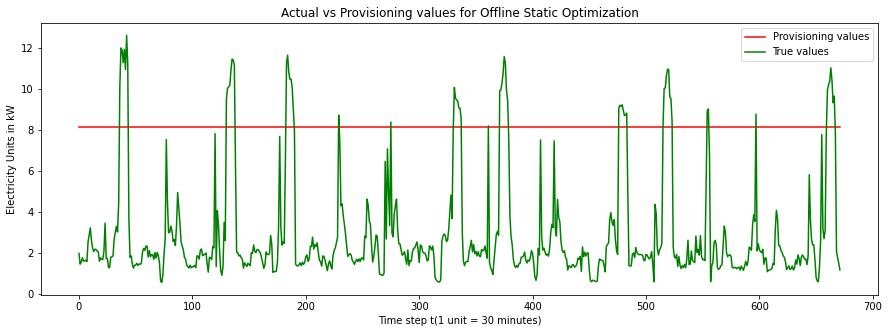

In [ ]:
plot_graph([x_offline_static_opt_home2]*672, home2, "Actual vs Provisioning values for Offline Static Optimization", "Provisioning values", "True values")

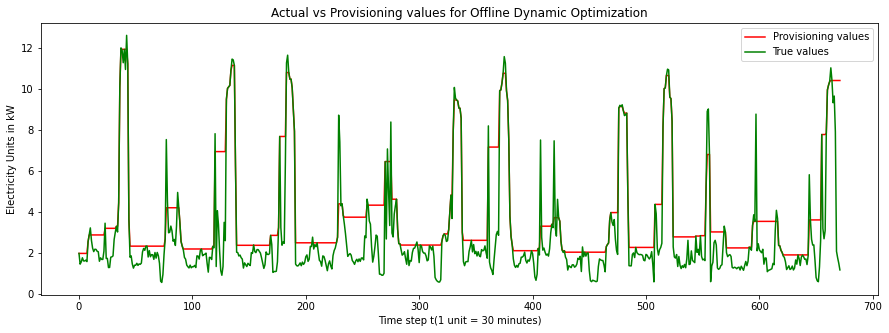

In [ ]:
plot_graph(x_offline_dyn_opt_home2, home2, "Actual vs Provisioning values for Offline Dynamic Optimization", "Provisioning values", "True values")

**Online Gradient Descent Provisioning Algorithm**

In [ ]:
def calculate_gradient(x, y, t, p, a, b):
    gradient_first_term = p
    gradient_second_term = -a if y[t] > x[t] else 0
    if x[t] > x[t - 1]:
      gradient_third_term = b
    elif x[t] < x[t - 1]:
      gradient_third_term = -b
    else:
      gradient_third_term = 0

    
    gradient = gradient_first_term + gradient_second_term + gradient_third_term
    
    return gradient

In [ ]:
def online_gradient_descent(y, learning_rate, p, a, b):
    n = len(y)
    x = [0.0] * n
    for t in range(n - 1):
        gradient = calculate_gradient(x, y, t, p, a, b)
        x[t + 1] = x[t] - learning_rate * gradient
    return x

In [ ]:
x = online_gradient_descent(home2.tolist(), 0.02, p, a, b)

In [ ]:
def cost(x, y, p, a, b):
    cost = 0.0
    for t in range(1, len(y)):      
        cost += p * x[t] + a * max(0, y[t] - x[t] )+ b * abs(x[t] - x[t - 1])
    return cost

In [ ]:
ogd_cost=cost(x, home2.tolist(), p, a, b)
print("\nThe objective value for Online Gradient Descent for Home2 is", ogd_cost)


The objective value for Online Gradient Descent for Home2 is 1729.1595799979993


In [ ]:
costs = []
learning_rates = []
lr = 0
for i in range(10000):
    lr += 0.00001
    x = online_gradient_descent(home2.tolist(), lr, p, a, b)
    learning_rates.append(lr)
    costs.append(cost(x ,home2.tolist(), p, a, b))

Text(0.5, 0, 'Learning rate')

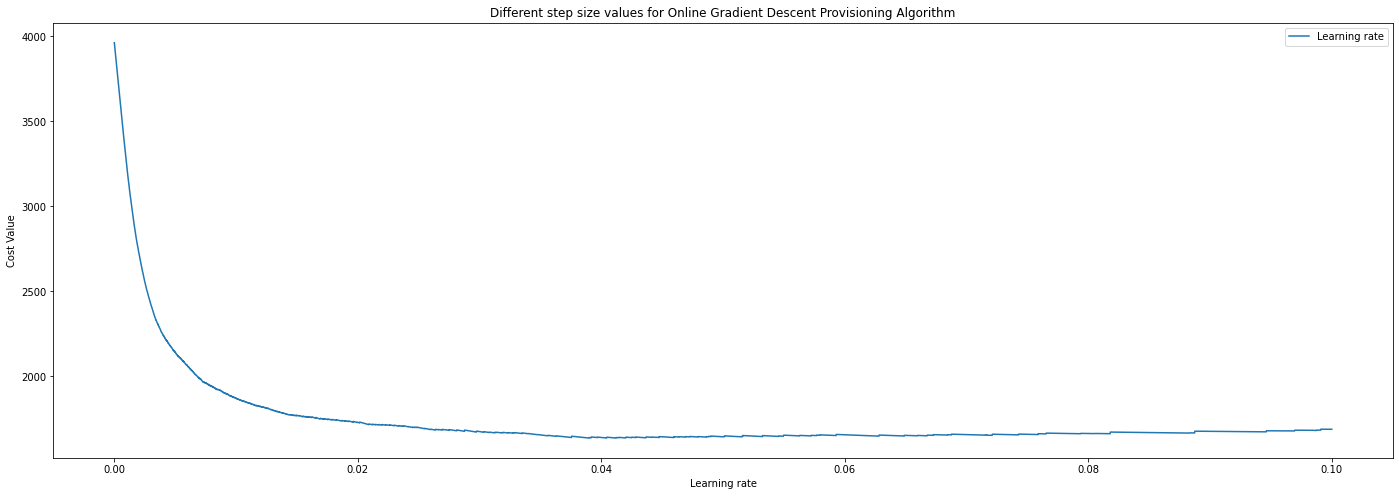

In [ ]:
fig = plt.figure(figsize=(24, 8))
plt.title("Different step size values for Online Gradient Descent Provisioning Algorithm")
plt.plot(learning_rates, costs, label = "Learning rate")
plt.legend()
plt.ylabel("Cost Value")
plt.xlabel("Learning rate")

In [ ]:
best_lr = learning_rates[costs.index(min(costs))]

In [ ]:
ogd_cost_home2 = online_gradient_descent(home2.tolist(), best_lr, p, a, b)
optimal_Values['OBD'] = ogd_cost_home2
decisions['OBD'] = cost(x, home2.tolist(), p, a, b)
print("Optimal cost found at step: ", best_lr)
print("\nOptimal cost using Online Gradient Descent is:", cost(x, home2.tolist(), p, a, b))

Optimal cost found at step:  0.041210000000001946

Optimal cost using Online Gradient Descent is: 1688.5580533360003


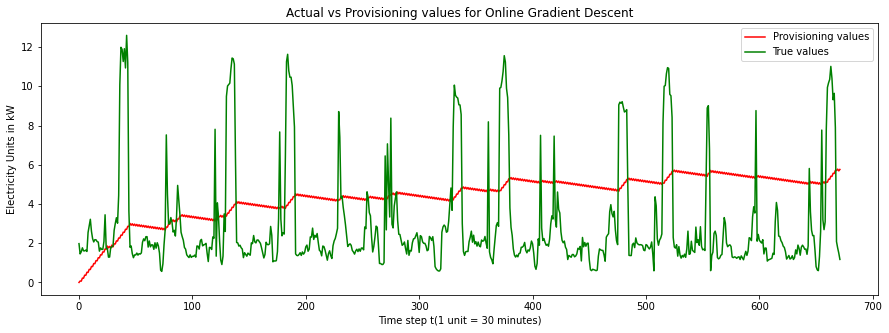

In [ ]:
plot_graph(ogd_cost_home2, home2, "Actual vs Provisioning values for Online Gradient Descent", "Provisioning values", "True values")

**RHC, CHC with the fixed values of a and b Using Predictions from the below models**
1. LSTM. 
2. ARIMA 
In Assignment 1, the above two methods had worked best for us, so we will obtain predictions results from these.


**Reciding Horizon Control (RHC)**






Data **Preprocessing**

---

Since we need to use predicted values in these two algorithms, I will be using hourly predictions for Home1,2,3. The data will undergo the follwing steps:
1. Filtering out the Date Range : 1 Dec to 14 Dec
2. Resampling the data into bi-hourly buckets.

In [ ]:
home2LSTM = pd.read_csv('/gdrive/MyDrive/Smart Energy/Electricity Provisioning/data/Home2LSTM.csv', sep=',', header=0, low_memory=True, infer_datetime_format=False, parse_dates={'datetime':[0]}, index_col=['datetime'])
home2LSTM = home2LSTM.resample('30T').mean()
home2LSTM = home2LSTM.interpolate()
home2LSTM=home2LSTM.reset_index()
home2LSTM=home2LSTM.rename(columns={"datetime":"Date & Time"})
home2LSTM = home2LSTM[np.logical_and(home2LSTM['Date & Time'] >= '2015-12-01', home2LSTM['Date & Time'] < '2015-12-15')]

In [ ]:
home2Arima = pd.read_csv('/gdrive/MyDrive/Smart Energy/Electricity Provisioning/data/Home2Arima.csv', sep=',', header=0, low_memory=True, infer_datetime_format=False, parse_dates={'datetime':[0]}, index_col=['datetime'])
home2Arima = home2Arima.resample('30T').mean()
home2Arima = home2Arima.interpolate()
home2Arima=home2Arima.reset_index()
home2Arima=home2Arima.rename(columns={"datetime":"Date & Time"})
home2Arima[np.logical_and(home2Arima['Date & Time'] >= '2015-12-01', home2Arima['Date & Time'] < '2015-12-15')]

,Date & Time,Usage [kW],predicted
0,2015-12-01 00:00:00,3.432574,5.167412
1,2015-12-01 00:30:00,3.381078,4.558710
2,2015-12-01 01:00:00,3.329581,3.950008
3,2015-12-01 01:30:00,3.276035,4.002132
4,2015-12-01 02:00:00,3.222489,4.054256
...,...,...,...
667,2015-12-14 21:30:00,10.689901,13.587414
668,2015-12-14 22:00:00,3.846014,12.883460
669,2015-12-14 22:30:00,3.258853,7.993838
670,2015-12-14 23:00:00,2.671692,3.104216


#Deterministic algorithm selection

In [ ]:
def ogd_k_steps(y, learning_rate, p, a, b, k):
  x = [0.0] * k
  for t in range(k - 1):
    gradient = calculate_gradient(x, y, t, p, a, b)
    x[t + 1] = x[t] - learning_rate * gradient
  return x

In [ ]:
def rhc_k_steps(data, p, a, b, win_size, k):
  x_k = [0.0] * k

  for i in range(k):
    window = data[i : i + win_size]
    objFunction = 0
    x = cp.Variable(win_size)

    for j in range(len(window)):
      if j == 0:
        objFunction += p * x[j] + (a * cp.maximum(0, window[j] - x[j])) + b * cp.abs(x[j])
      else :
        objFunction += p * x[j] + (a * cp.maximum(0, window[j] - x[j])) + b * cp.abs(x[j]-x[j-1])
    
    problem = cp.Problem(cp.Minimize(objFunction))
    result = problem.solve()
    x_k[i] = x.value[0]

  return x_k

In [ ]:
def chc_k_steps(data, p, a, b, win_size, commitment_level, k):
  x_k = [0.0] * k
  
  for i in range(k):
    window = data[i : i + win_size]
    objFunction = 0
    x = cp.Variable(win_size)
    
    for j in range(len(window)):
      if j == 0:
        objFunction += p * x[j] + (a * cp.maximum(0, window[j] - x[j])) + b * cp.abs(x[j])
      else :
        objFunction += p * x[j] + (a * cp.maximum(0, window[j] - x[j])) + b * cp.abs(x[j]-x[j-1])
    
    problem = cp.Problem(cp.Minimize(objFunction))
    result = problem.solve()
    x_k[i] = np.mean(x.value[:commitment_level])

  return x_k

In [ ]:
def deterministic_selection(y, y_hat, history_size):

  #print(y)
  #print(y_hat)
  algorithms_score = {'OGD' : 0, 'RHC': 0, 'CHC': 0}
  x = []

  num_rounds = len(y) // history_size

  p = 0.4/2
  a = 4/2
  b = 4/2

  rhc_window = 8
  chc_window = 6
  commitment_level = 2

  x_best = []

  x_ogd = ogd_k_steps(y_hat[:history_size + 1], best_lr, p, a, b, history_size)
  ogd_cost = cost(x_ogd, y_hat[:history_size], p, a, b)  

  x_rhc = rhc_k_steps(y_hat[:history_size], p, a, b, rhc_window, history_size)
  rhc_cost = cost(x_rhc, y_hat[:history_size], p, a ,b)

  x_chc = chc_k_steps(y_hat[:history_size], p, a, b, chc_window, commitment_level, history_size)
  chc_cost = cost(x_chc, y_hat[:history_size], p, a ,b)

  min_cost = min(ogd_cost, rhc_cost, chc_cost)

  if ogd_cost == min_cost:
    algorithms_score['OGD'] = algorithms_score['OGD'] + 1
    ogd_prov = ogd_k_steps(y_hat[: history_size + 1], best_lr, p, a, b, history_size)
    x_best.extend(ogd_prov)
  elif rhc_cost == min_cost:
    algorithms_score['RHC'] = algorithms_score['RHC'] + 1
    rhc_prov = rhc_k_steps(y_hat[: history_size], p, a, b, rhc_window, history_size)
    x_best.extend(rhc_prov)
  elif chc_cost == min_cost:
    algorithms_score['CHC'] = algorithms_score['CHC'] + 1
    chc_prov = chc_k_steps(y_hat[: history_size], p, a, b, chc_window, commitment_level, history_size)
    x_best.extend(chc_prov)

  for start in range(0, len(y) - history_size, history_size):
    x_ogd = ogd_k_steps(y_hat[start : start + history_size + 1], best_lr, p, a, b, history_size)
    ogd_cost = cost(x_ogd, y_hat[start : start + history_size], p, a, b)
    
    x_rhc = rhc_k_steps(y_hat[start : start + history_size], p, a, b, rhc_window, history_size)
    rhc_cost = cost(x_rhc, y_hat[start : start + history_size], p, a ,b)

    x_chc = chc_k_steps(y_hat[start : start + history_size], p, a, b, chc_window, commitment_level, history_size)
    chc_cost = cost(x_chc, y_hat[start : start + history_size], p, a ,b)  

    min_cost = min(ogd_cost, rhc_cost, chc_cost)
    if ogd_cost == min_cost:
      algorithms_score['OGD'] = algorithms_score['OGD'] + 1
      ogd_prov = ogd_k_steps(y_hat[start + history_size: start + 2 * history_size + 1], best_lr, p, a, b, history_size)
      x_best.extend(ogd_prov)
    elif rhc_cost == min_cost:
      algorithms_score['RHC'] = algorithms_score['RHC'] + 1
      rhc_prov = rhc_k_steps(y_hat[start + history_size: start + 2 * history_size], p, a, b, rhc_window, history_size)
      x_best.extend(rhc_prov)
    elif chc_cost == min_cost:
      algorithms_score['CHC'] = algorithms_score['CHC'] + 1
      chc_prov = chc_k_steps(y_hat[start : start + history_size], p, a, b, chc_window, commitment_level, history_size)
      x_best.extend(chc_prov)
  
  return x_best, algorithms_score

In [ ]:
x, algorithms_score = deterministic_selection(home2.tolist(), home2LSTM['forecast'].tolist(), 16)

In [ ]:
print(algorithms_score)

{'OGD': 0, 'RHC': 17, 'CHC': 25}


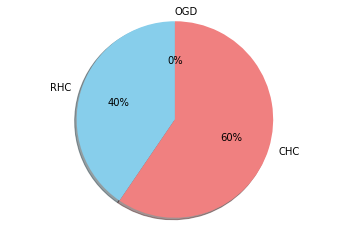

In [ ]:
fig1, ax1 = plt.subplots()
ax1.pie(algorithms_score.values(), labels=algorithms_score.keys(), shadow=True, startangle=90, autopct='%1.0f%%', colors=['lightcoral', 'skyblue'])
ax1.axis('equal')
plt.show()

In [ ]:
for i in range(5):
  x, algorithms_score = deterministic_selection(home2.tolist(), home2LSTM['forecast'].tolist(), 16)
  print("Match #" + str(i + 1) + ": Algorithms score: " + str(algorithms_score))

Match #1: Algorithms score: {'OGD': 0, 'RHC': 17, 'CHC': 25}
Match #2: Algorithms score: {'OGD': 0, 'RHC': 17, 'CHC': 25}
Match #3: Algorithms score: {'OGD': 0, 'RHC': 17, 'CHC': 25}
Match #4: Algorithms score: {'OGD': 0, 'RHC': 17, 'CHC': 25}
Match #5: Algorithms score: {'OGD': 0, 'RHC': 17, 'CHC': 25}


In [ ]:
print(len(home2LSTM['forecast'].tolist()))

672


In [ ]:
cost(x, home2LSTM['forecast'].tolist(), 0.2, 2, 2)

5162.348365519168

# Randomized Selection

In [ ]:
import random

def randomized_selection(y, y_hat, history_size, bonus):

  algorithms_score = {'OGD' : 0, 'RHC': 0, 'CHC': 0}
  algorithms_weight = {'OGD' : 1/3, 'RHC': 1/3, 'CHC': 1/3}
  x = []

  num_rounds = len(y) // history_size

  p = 0.4/2
  a = 4/2
  b = 4/2

  rhc_window = 8
  chc_window = 6
  commitment_level = 2

  x_best = []

  x_ogd = ogd_k_steps(y_hat[:history_size + 1], best_lr, p, a, b, history_size)
  ogd_cost = cost(x_ogd, y_hat[:history_size], p, a, b)  

  x_rhc = rhc_k_steps(y_hat[:history_size], p, a, b, rhc_window, history_size)
  rhc_cost = cost(x_rhc, y_hat[:history_size], p, a ,b)

  x_chc = chc_k_steps(y_hat[:history_size], p, a, b, chc_window, commitment_level, history_size)
  chc_cost = cost(x_chc, y_hat[:history_size], p, a ,b)

  min_cost = min(ogd_cost, rhc_cost, chc_cost)
  max_cost = max(ogd_cost, rhc_cost, chc_cost)

  if ogd_cost == min_cost:
    algorithms_weight['OGD'] = algorithms_weight['OGD'] + bonus
  elif rhc_cost == min_cost:
    algorithms_weight['RHC'] = algorithms_weight['RHC'] + bonus
  elif chc_cost == min_cost:
    algorithms_weight['CHC'] = algorithms_weight['CHC'] + bonus

  if ogd_cost == max_cost:
    algorithms_weight['OGD'] = algorithms_weight['OGD'] - bonus
  elif rhc_cost == max_cost:
    algorithms_weight['RHC'] = algorithms_weight['RHC'] - bonus
  elif chc_cost == max_cost:
    algorithms_weight['CHC'] = algorithms_weight['CHC'] - bonus

  algo = random.choices(list(algorithms_weight.keys()), weights=algorithms_weight.values(), k=1)[0]

  if algo == 'OGD':
    algorithms_score['OGD'] = algorithms_score['OGD'] + 1
    ogd_prov = ogd_k_steps(y_hat[: history_size + 1], best_lr, p, a, b, history_size)
    x_best.extend(ogd_prov)
  elif algo == 'RHC':
    algorithms_score['RHC'] = algorithms_score['RHC'] + 1
    rhc_prov = rhc_k_steps(y_hat[: history_size], p, a, b, rhc_window, history_size)
    x_best.extend(rhc_prov)
  elif algo == 'CHC':
    algorithms_score['CHC'] = algorithms_score['CHC'] + 1
    chc_prov = chc_k_steps(y_hat[: history_size], p, a, b, chc_window, commitment_level, history_size)
    x_best.extend(chc_prov)

  for start in range(0, len(y) - history_size, history_size):

    x_ogd = ogd_k_steps(y_hat[start : start + history_size + 1], best_lr, p, a, b, history_size)
    ogd_cost = cost(x_ogd, y_hat[start : start + history_size], p, a, b)
    
    x_rhc = rhc_k_steps(y_hat[start : start + history_size], p, a, b, rhc_window, history_size)
    rhc_cost = cost(x_rhc, y_hat[start : start + history_size], p, a ,b)

    x_chc = chc_k_steps(y_hat[start : start + history_size], p, a, b, chc_window, commitment_level, history_size)
    chc_cost = cost(x_chc, y_hat[start : start + history_size], p, a ,b)  

    min_cost = min(ogd_cost, rhc_cost, chc_cost)
    max_cost = max(ogd_cost, rhc_cost, chc_cost)

    # give bonus
    if ogd_cost == min_cost:
      algorithms_weight['OGD'] = algorithms_weight['OGD'] + bonus
    elif rhc_cost == min_cost:
      algorithms_weight['RHC'] = algorithms_weight['RHC'] + bonus
    elif chc_cost == min_cost:
      algorithms_weight['CHC'] = algorithms_weight['CHC'] + bonus

    # give penalty
    if ogd_cost == max_cost:
      algorithms_weight['OGD'] = algorithms_weight['OGD'] - bonus
    elif rhc_cost == max_cost:
      algorithms_weight['RHC'] = algorithms_weight['RHC'] - bonus
    elif chc_cost == max_cost:
      algorithms_weight['CHC'] = algorithms_weight['CHC'] - bonus

    # randomly choose algorithm with weights
    algo = random.choices(list(algorithms_weight.keys()), weights=algorithms_weight.values(), k=1)[0]

    if algo == 'OGD':
      algorithms_score['OGD'] = algorithms_score['OGD'] + 1
      ogd_prov = ogd_k_steps(y_hat[start + history_size: start + 2 * history_size + 1], best_lr, p, a, b, history_size)
      x_best.extend(ogd_prov)
    elif algo == 'RHC':
      algorithms_score['RHC'] = algorithms_score['RHC'] + 1
      rhc_prov = rhc_k_steps(y_hat[start + history_size: start + 2 * history_size], p, a, b, rhc_window, history_size)
      x_best.extend(rhc_prov)
    elif algo == 'CHC':
      algorithms_score['CHC'] = algorithms_score['CHC'] + 1
      chc_prov = chc_k_steps(y_hat[start : start + history_size], p, a, b, chc_window, commitment_level, history_size)
      x_best.extend(chc_prov)
  
  return x_best, algorithms_score, algorithms_weight

In [ ]:
x, algorithms_score, algorithms_weight = randomized_selection(home2.tolist(), home2LSTM['forecast'].tolist(), 16, 0.01)

In [ ]:
print(algorithms_score)

{'OGD': 4, 'RHC': 18, 'CHC': 20}


Match #1: Algorithms score: {'OGD': 11, 'RHC': 17, 'CHC': 14} Algorithms weight: {'OGD': 0.03933333333333308, 'RHC': 0.4523333333333334, 'CHC': 0.5083333333333334}
Match #2: Algorithms score: {'OGD': 10, 'RHC': 15, 'CHC': 17} Algorithms weight: {'OGD': 0.03933333333333308, 'RHC': 0.4523333333333334, 'CHC': 0.5083333333333334}
Match #3: Algorithms score: {'OGD': 11, 'RHC': 18, 'CHC': 13} Algorithms weight: {'OGD': 0.03933333333333308, 'RHC': 0.4523333333333334, 'CHC': 0.5083333333333334}
Match #4: Algorithms score: {'OGD': 6, 'RHC': 16, 'CHC': 20} Algorithms weight: {'OGD': 0.03933333333333308, 'RHC': 0.4523333333333334, 'CHC': 0.5083333333333334}
Match #5: Algorithms score: {'OGD': 5, 'RHC': 15, 'CHC': 22} Algorithms weight: {'OGD': 0.03933333333333308, 'RHC': 0.4523333333333334, 'CHC': 0.5083333333333334}


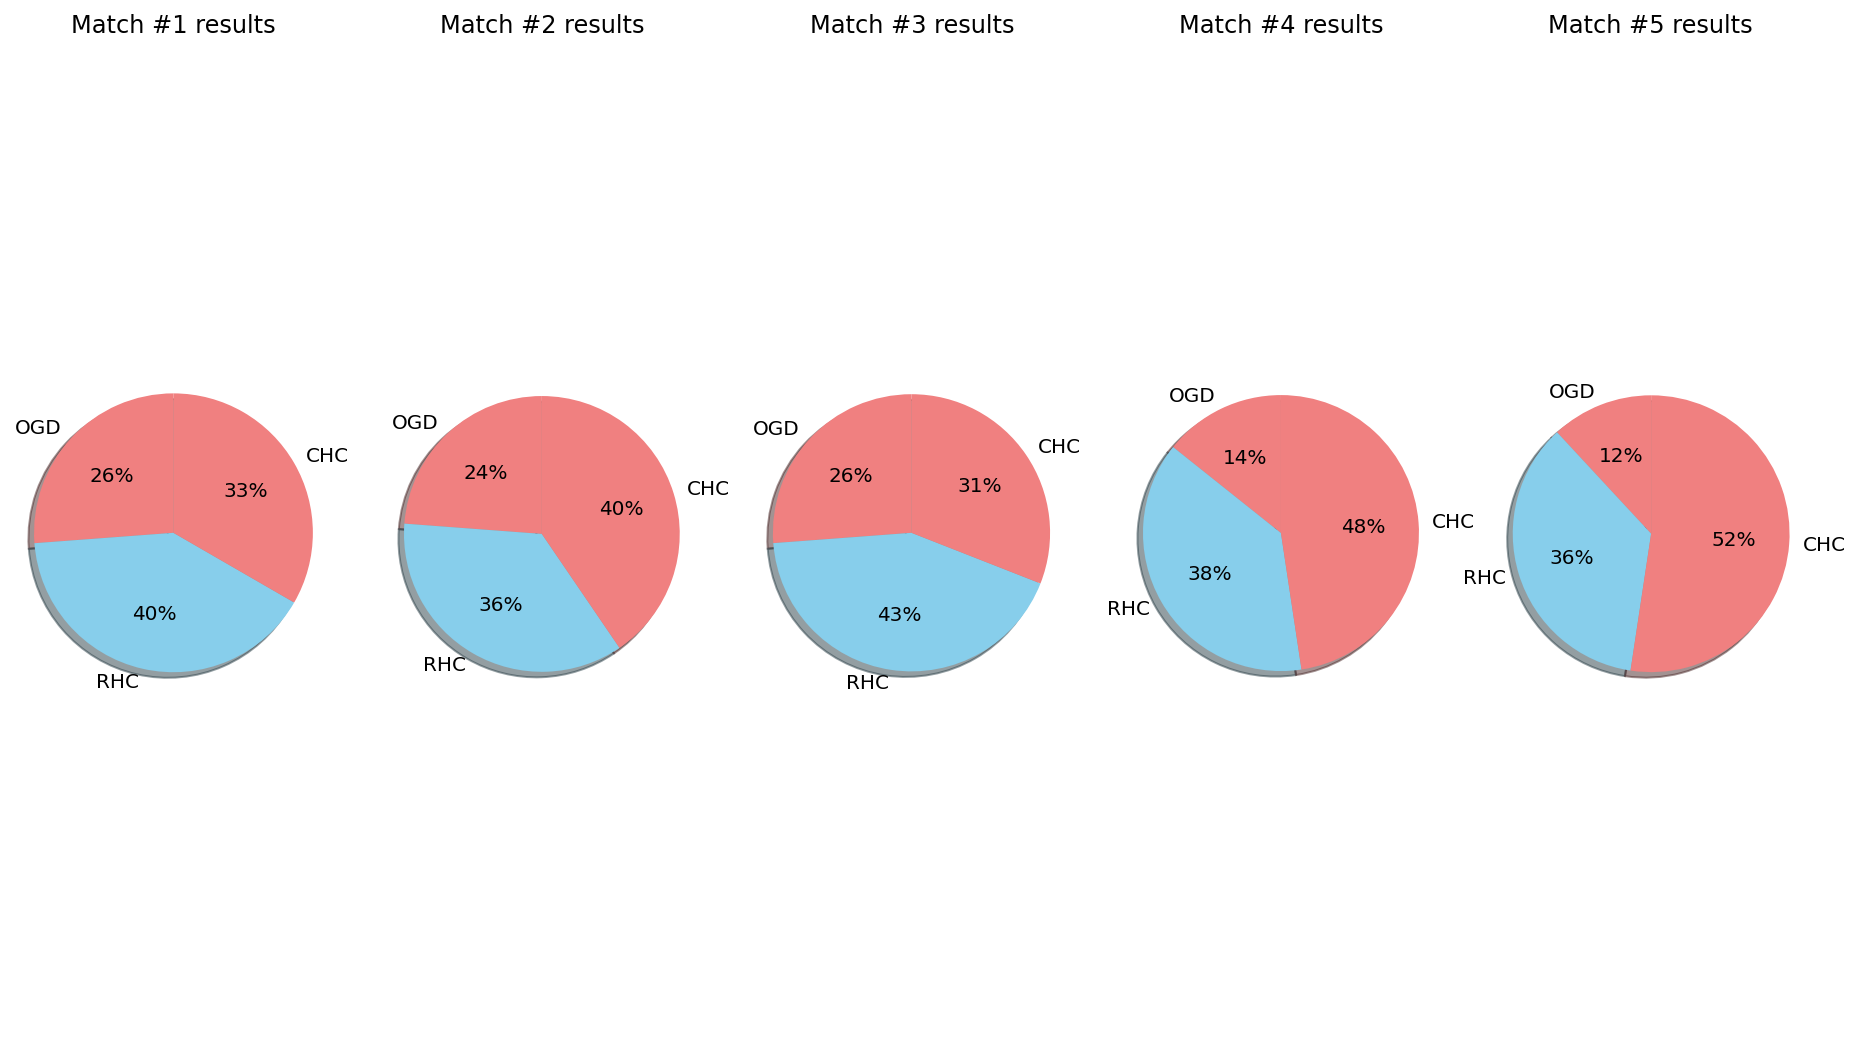

In [ ]:
fig = plt.figure(figsize=(16,9),dpi=144)

for i in range(5):
  x, algorithms_score, algorithms_weight = randomized_selection(home2.tolist(), home2LSTM['forecast'].tolist(), 16, 0.007)
  print("Match #" + str(i + 1) + ": Algorithms score: " + str(algorithms_score) + ' Algorithms weight: ' + str(algorithms_weight))
  ax = fig.add_subplot(1, 5, i + 1)
  ax.pie(algorithms_score.values(), labels=algorithms_score.keys(), shadow=True, startangle=90, autopct='%1.0f%%', colors=['lightcoral', 'skyblue'])
  ax.set_title('Match #' + str(i + 1) + " results")
  ax.axis('equal')

plt.show()